# Exam Project

In [2]:
# Resizing images
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.support.ui import Select
from selenium.webdriver.common.keys import Keys
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import os
import glob
import random
import bs4
import requests
import time


trainingdata= glob.glob('./TraningData/*.jpg')
testingdata= glob.glob('./TestingData/*.jpg')

In [3]:
def getTestingData(array, list, x=120, y=50):
    print("Preparing testing images")
    tmp_testing_images = []
    tmp_testing_labels = []
    class_names = array 
    
    shuffled_list = random.sample(list, len(list))
    

    for i in shuffled_list:
        object_name = os.path.basename(i).split('_')[0].lower() + " " + os.path.basename(i).split('_')[1]
        resized_img = cv.resize(cv.imread(i), (x, y))
        resized_img = cv.cvtColor(resized_img, cv.COLOR_BGR2GRAY)
        tmp_testing_images.append(resized_img)
        index = class_names.index(object_name)
        tmp_testing_labels.append(index)
    #Transforms arrays to numpy arrays        
    testing_images = np.asarray(tmp_testing_images).reshape(len(list) , x, y, 1)
    testing_labels = np.asarray(tmp_testing_labels)
                              
    return testing_images, testing_labels


def getData(list, x=120, y=50):
    print("Preparing training images")
    tmp_training_images = []
    tmp_training_labels = []
    class_names = []
    
    shuffled_list = random.sample(list, len(list))
    
    
    
    for i in shuffled_list:
        resized_img = cv.resize(cv.imread(i), (x, y))
        resized_img = cv.cvtColor(resized_img, cv.COLOR_BGR2GRAY)
        
        tmp_training_images.append(resized_img)
        
        object_name = os.path.basename(i).split('_')[0].lower() + " " + os.path.basename(i).split('_')[1]
        #If car (object_name) exists in class_names
        if object_name in class_names:
            #Take index of that car (object_name) in class_names and append it to tmp_training_labels
            index = class_names.index(object_name)
            tmp_training_labels.append(index)
        else:
            #Append car (object_name) to class_names, take index of car (object_name) in class_names, append index to tmp_training_labels 
            class_names.append(object_name)
            index = class_names.index(object_name)
            tmp_training_labels.append(index)
            
    #Transforms arrays to numpy arrays        
    training_images = np.asarray(tmp_training_images).reshape(len(list) , x, y, 1)
    training_labels = np.asarray(tmp_training_labels)
                               
    return training_images, training_labels, class_names

In [8]:
pixel_x = 64
pixel_y = 64

training_images, training_labels, class_names = getData(trainingdata, pixel_x, pixel_y) ## Skal skiftes ud til vores dataset
testing_images, testing_labels = getTestingData(class_names, testingdata, pixel_x, pixel_y)
training_images, testing_images = training_images / 255, testing_images / 255 # preparing the data

print(class_names)


model = models.Sequential()
model.add(layers.Conv2D(64, (3,3), activation= "relu", input_shape=(pixel_x, pixel_y, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation= "relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(256, (5,5), activation= "relu"))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = "relu"))
model.add(layers.Dense(len(class_names), activation = "softmax"))

model.summary()




model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(training_images, training_labels, epochs=25, validation_data=(testing_images, testing_labels))
loss, accuracy = model.evaluate(testing_images, testing_labels)

print(f'Loss: {loss}')
print(f"Accuracy: {accuracy}")
model.save('lort_classifier.model')


Preparing training images
Preparing testing images
['fiat 500', 'audi R8']


In [20]:
def predict(image, pixel_x=64, pixel_y=64):
    print("I Think this is a ....")
    model = models.load_model('image_classifier.model') 

    img = cv.imread(image)
    img_root = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    class_names = ["Audi R8", "Fiat 500"]
    img = cv.resize(img_root, (pixel_x, pixel_y))
    prediction = model.predict(np.array([img]).reshape(1, pixel_x, pixel_y, 1) / 255)
    index = np.argmax(prediction)
    print(f'{class_names[index]}, defenently a {class_names[index]}')
    return class_names[index]

In [18]:
def find_car(predict):
    print("Finding you a new car")
    
    try:
        original_url = 'https://www.bilbasen.dk'
        options = Options()
        options.headless = True
        browser = webdriver.Firefox(options = options)

        browser.get(original_url)
        browser.implicitly_wait(5)
        popUpButton = browser.find_element_by_id("onetrust-accept-btn-handler")
        popUpButton.click()
        searchBar = browser.find_element_by_class_name('react-autosuggest__input')
        searchBar.send_keys(predict)
        searchBar.send_keys(Keys.RETURN)
        
        boolean_check_for_next = True
        time.sleep(5)
        url_array = []

        while boolean_check_for_next:
            url_array.append(browser.current_url) 
            try:
                if browser.find_element_by_class_name("next"):
                    browser.find_element_by_class_name("next").click()
            except:
                boolean_check_for_next = False
        car_price = []
        headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
        print("Here they come!!")
        for url in url_array:
            url = url.replace("includeleasing=true", "includeleasing=false")
            url = url.replace("includeLeasing=true", "includeLeasing=false")
            req = requests.get(url, headers=headers)
            soup = bs4.BeautifulSoup(req.text, 'html.parser')
            mydivs = soup.find_all("div", {"class": "row listing listing-plus bb-listing-clickable"})

            
            for car in mydivs:

                price = car.find("div", {"class" : "col-xs-3 listing-price"}).text
                data = car.find_all("div", {"class" : "col-xs-2 listing-data"})
                km = data[1].text
                year = data[2].text
                
                
                print(f'Bil: {predict}')
                if price == "Ring":
                    print(f'Pris: Ring')
                else:
                    price = price.split(' ')[0].split('.')
                    print(f'Pris: {price[0]+price[1]}')
                print(f'År: {year}')
                print(f'Km: {km}')
                print(f'-------------')
                car_price.append(price[0]+price[1])
        print("All Done!")
        print(" ")
    finally:
        browser.quit()

In [19]:
find_car(predict("./TestingData/FIAT_500_10.jpg"))




I Think thiss is a ....
Audi R8, defenently a Audi R8
Finding you a new car
Here they come!!
Bil: Audi R8
Pris: Ring
År: 2010
Km: 14.000
-------------
Bil: Audi R8
Pris: 399995
År: 2008
Km: 71.000
-------------
Bil: Audi R8
Pris: 1299
År: 2014
Km: 28.000
-------------
Bil: Audi R8
Pris: 4150
År: 2014
Km: 49.000
-------------
Bil: Audi R8
Pris: 450000
År: 2013
Km: 75.000
-------------
Bil: Audi R8
Pris: 219999
År: 2008
Km: 99.000
-------------
All Done!


Prediction is fiat 500
Car is: audi R8
Prediction is False


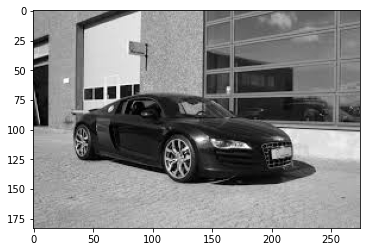

-------------------
Prediction is audi R8
Car is: fiat 500
Prediction is False


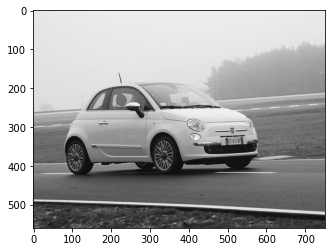

-------------------
Prediction is fiat 500
Car is: audi R8
Prediction is False


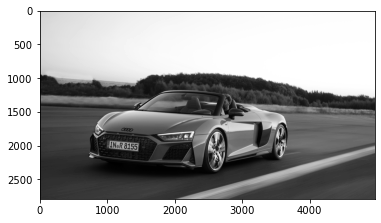

-------------------
Prediction is audi R8
Car is: audi R8
Prediction is True
-------------------
Prediction is fiat 500
Car is: fiat 500
Prediction is True
-------------------
Prediction is audi R8
Car is: audi R8
Prediction is True
-------------------
Prediction is fiat 500
Car is: fiat 500
Prediction is True
-------------------
Prediction is audi R8
Car is: audi R8
Prediction is True
-------------------
Prediction is audi R8
Car is: audi R8
Prediction is True
-------------------
Prediction is fiat 500
Car is: fiat 500
Prediction is True
-------------------
Prediction is audi R8
Car is: audi R8
Prediction is True
-------------------
Prediction is fiat 500
Car is: fiat 500
Prediction is True
-------------------
Prediction is audi R8
Car is: audi R8
Prediction is True
-------------------
Prediction is audi R8
Car is: fiat 500
Prediction is False


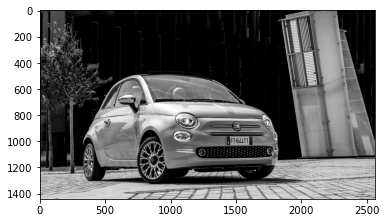

-------------------
Prediction is fiat 500
Car is: audi R8
Prediction is False


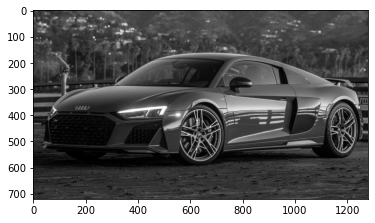

-------------------
Prediction is fiat 500
Car is: fiat 500
Prediction is True
-------------------
Prediction is audi R8
Car is: audi R8
Prediction is True
-------------------
Prediction is fiat 500
Car is: fiat 500
Prediction is True
-------------------
Prediction is fiat 500
Car is: fiat 500
Prediction is True
-------------------
Prediction is fiat 500
Car is: fiat 500
Prediction is True
-------------------
Rigtige gæt: 75.0%
5
15


In [17]:
#Test af model

model = models.load_model('image_classifier.model')
accuracy = []
img_array = testingdata

random.shuffle(img_array)

for i in img_array:
    img_name = os.path.basename(i).split('_')[0].lower() + " " + os.path.basename(i).split('_')[1]
    
    img = cv.imread(i)
    img_root = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    img = cv.resize(img_root, (pixel_x, pixel_y))
    prediction = model.predict(np.array([img]).reshape(1, pixel_x, pixel_y, 1) / 255)
    index = np.argmax(prediction)
    print(f'Prediction is {class_names[index]}')
    print(f'Car is: {img_name}')
    if class_names[index] == img_name:
        print(f'Prediction is True')
        accuracy.append(True)
    else:
        print(f'Prediction is False')
        plt.imshow(img_root, cmap=plt.cm.gray)
        plt.show()
        accuracy.append(False)
    print('-------------------')
print(f'Rigtige gæt: {100 - (accuracy.count(False)/len(img_array))*100}%')
print(accuracy.count(False))
print(accuracy.count(True))

In [ ]:
"""
def resize(imgs):
    print(imgs)
    for i in imgs:
        img = cv.imread(i)
        resize_img = cv.resize(img, (32, 32))
        cv.imwrite(i, resize_img)
resize(imgs)
"""